## XAI - Fraud Detection

#### 1. Develop model
#### 2. Generate SHAP values
#### 3. Local Interpretation
#### 4. Global Interpretation


1. Develop Model


In [ ]:
##Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
#Load data
train_df = pd.read_csv("fraudTrain.csv",nrows=300000)
train_df.dropna(inplace=True)
test_df = pd.read_csv("fraudTest.csv",nrows=200000)
test_df.dropna(inplace=True)

In [ ]:
#Data Summary
print (train_df.shape)
print (test_df.shape)
train_df.head()

(300000, 23)
(200000, 23)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
# Install libraries
! pip install geopy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Feature Engineering

def age_computer(date, time_format = "%Y-%m-%d"):
    dob_formatted = datetime.strptime(date, time_format)
    dob_year = dob_formatted.year
    age = datetime.now().year - dob_year
    return age

def txn_month_extractor(txn_date, time_format = "%Y-%m-%d %H:%M:%S"):
    date_formatted = datetime.strptime(txn_date, time_format)
    month = date_formatted.month
    return month

train_df["age"] = train_df.dob.apply(lambda x: age_computer(x))
train_df["txn_mth"] = train_df.trans_date_trans_time.apply(lambda x: txn_month_extractor(x))

import geopy.distance

def distance_computer(cust_lat, cust_long, merch_lat, merch_long):
    coords_1 = cust_lat, cust_long
    coords_2 = merch_lat, merch_long
    return round(geopy.distance.geodesic(coords_1, coords_2).km, 3)

def age_segment_computer(age):
    if age <= 20:
        return "SEG1"
    elif age > 20 and age <= 30:
        return "SEG2"
    elif age > 30 and age <= 58:
        return "SEG3"
    else:
        return "SEG4"

def distance_segment_computer(dist):
    if dist <= near_distance_limit:
        return "NEAR"
    elif dist > near_distance_limit and dist <= moderate_distance_limit:
        return "MODERATE"
    else:
        return "LONG"

def percent_agg(series):
    return sum(series)*100/len(series)

train_df["distance"] = train_df.apply(lambda x: distance_computer(x["lat"], x["long"], x["merch_lat"], x["merch_long"]), axis=1)
useful_columns = ["merchant", "category", "amt", "gender", "state", "city_pop", "job", "age", "txn_mth", "distance", "is_fraud"]
train_df_processed = train_df[useful_columns].copy()
#df_txn_mth_plot = train_df_processed.groupby(["txn_mth"]).agg({"is_fraud":["sum", "count", percent_agg]})

train_df_processed["age_sgement"] = train_df_processed.age.apply(lambda x: age_segment_computer(x))
#df_age_seg_plot = train_df_processed.groupby(["age_sgement"]).agg({"is_fraud":["sum", "count", percent_agg]})

near_distance_limit = np.percentile(train_df_processed.distance, 20)
moderate_distance_limit = np.percentile(train_df_processed.distance, 70)
print(f"near distance limit 0 - {near_distance_limit}")
print(f"moderate distance limit {near_distance_limit} - {moderate_distance_limit}")
print(f"long distance limit {moderate_distance_limit} - {train_df_processed.distance.max()}")

train_df_processed["dist_segment"] = train_df_processed.distance.apply(lambda x: distance_segment_computer(x))
#df_dist_seg_plot = train_df_processed.groupby(["dist_segment"]).agg({"is_fraud":["sum", "count", percent_agg]})

train_x = train_df_processed[["merchant", "category", "amt", "gender", "state", "city_pop", "job", "age", "txn_mth", "distance"]].copy()
train_y = train_df_processed.is_fraud

train_x_numeric = train_x.drop(["merchant", "category", "gender", "state", "job"], axis=1)
train_x_cat = train_x[["merchant", "category", "gender", "state", "job"]]


from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
enc.fit(train_x_cat)
train_x_cat_encoded = enc.transform(train_x_cat)
train_x_cat_encoded = pd.DataFrame(train_x_cat_encoded, columns=["merchant", "category", "gender", "state", "job"])
final_x_train = pd.concat([train_x_numeric, train_x_cat_encoded], axis=1)


test_df["age"] = test_df.dob.apply(lambda x: age_computer(x))
test_df["txn_mth"] = test_df.trans_date_trans_time.apply(lambda x: txn_month_extractor(x))
test_df["distance"] = test_df.apply(lambda x: distance_computer(x["lat"], x["long"], x["merch_lat"], x["merch_long"]), axis=1)

test_x = test_df[["merchant", "category", "amt", "gender", "state", "city_pop", "job", "age", "txn_mth", "distance"]].copy()
test_y = test_df.is_fraud

test_x_numeric = test_x.drop(["merchant", "category", "gender", "state", "job"], axis=1)
test_x_cat = test_x[["merchant", "category", "gender", "state", "job"]]

test_x_cat_encoded = enc.transform(test_x_cat)
test_x_cat_encoded = pd.DataFrame(test_x_cat_encoded, columns=["merchant", "category", "gender", "state", "job"])
final_x_test = pd.concat([test_x_numeric, test_x_cat_encoded], axis=1)

print(f"shape of Train data: {final_x_train.shape}")
print(f"shape of Test data: {final_x_test.shape}")


near distance limit 0 - 49.492
moderate distance limit 49.492 - 94.166
long distance limit 94.166 - 150.58
shape of Train data: (300000, 10)
shape of Test data: (200000, 10)


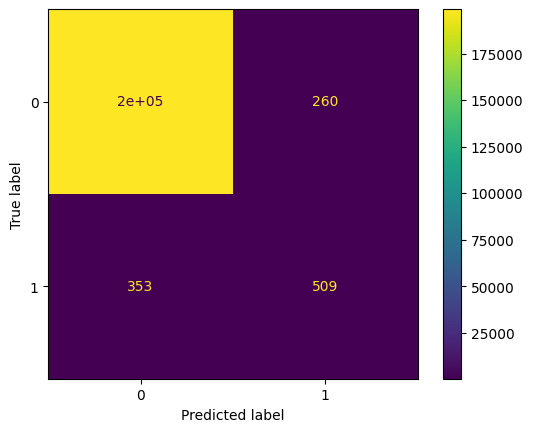

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199138
           1       0.66      0.59      0.62       862

    accuracy                           1.00    200000
   macro avg       0.83      0.79      0.81    200000
weighted avg       1.00      1.00      1.00    200000



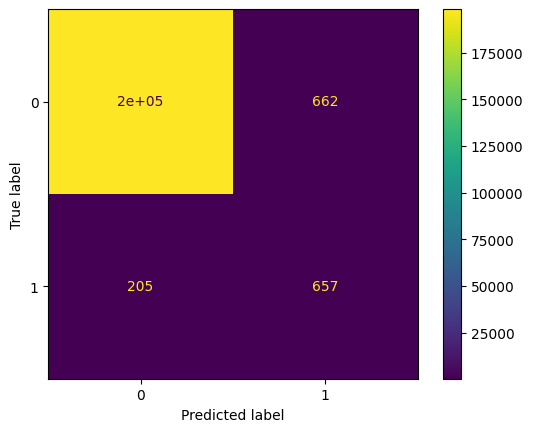

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199138
           1       0.50      0.76      0.60       862

    accuracy                           1.00    200000
   macro avg       0.75      0.88      0.80    200000
weighted avg       1.00      1.00      1.00    200000



In [ ]:
# Fraud Detection Model

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(max_depth=10)
clf.fit(final_x_train, train_y)

predictions = clf.predict(final_x_test)
cm = confusion_matrix(test_y, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

print(classification_report(test_y, predictions, labels=clf.classes_))

#Hyper Parameter Tuning

clf = DecisionTreeClassifier(max_depth=10, class_weight={0:1, 1:10})
clf.fit(final_x_train, train_y)


predictions = clf.predict(final_x_test)
cm = confusion_matrix(test_y, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

print(classification_report(test_y, predictions, labels=clf.classes_))

2. Generate SHAP values

In [ ]:
# Install SHAP
%pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 12.4 MB/s eta 0:00:00


DETAILS : <br>
model - clf (Decision Tree Classifier) <br>
train data - final_x_train <br>
train data columns - ['amt', 'city_pop', 'age', 'txn_mth', 'distance', 'merchant', 'category',
       'gender', 'state', 'job'] <br>

SAMPLE RECORDS: <br>
isFraud - 2449 <br>
isnotFraud - 2,678 <br>

In [ ]:
#XAI using SHAP
import shap
explainer = shap.TreeExplainer(model=clf,
                               data=None,
                               model_output='raw',
                               feature_perturbation='tree_path_dependent')

shap_values = explainer.shap_values(final_x_train)

#SHAP values summary
print(f'Shape of dataset: {final_x_train.shape}')
print(f'Type of shap_values: {type(shap_values)}. Length of the list: {len(shap_values)}')
print(f'Shape of shap_values: {np.array(shap_values).shape}')



Shape of dataset: (300000, 10)
Type of shap_values: <class 'list'>. Length of the list: 2
Shape of shap_values: (2, 300000, 10)


SHAP EXPLANATION:

1. BASE VALUE
2. MODEL PREDICTED VALUE
3. SHAP VALUE CONTRIBUTION (POSITIVE / NEGATIVE)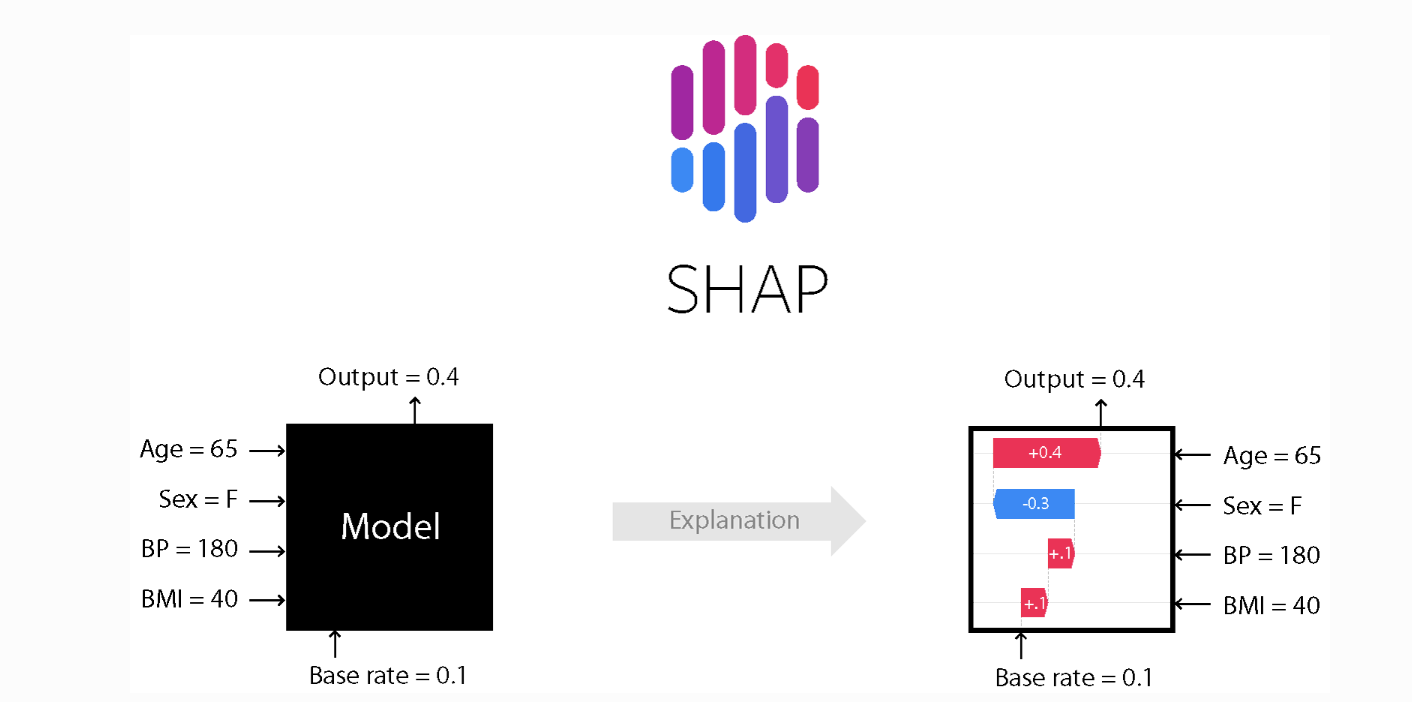

3.  Local Interpretation

3.1 Waterfall plot


A waterfall chart displays the contributions of each feature to the final prediction in a step-by-step manner, with each step representing the incremental contribution of a single feature.

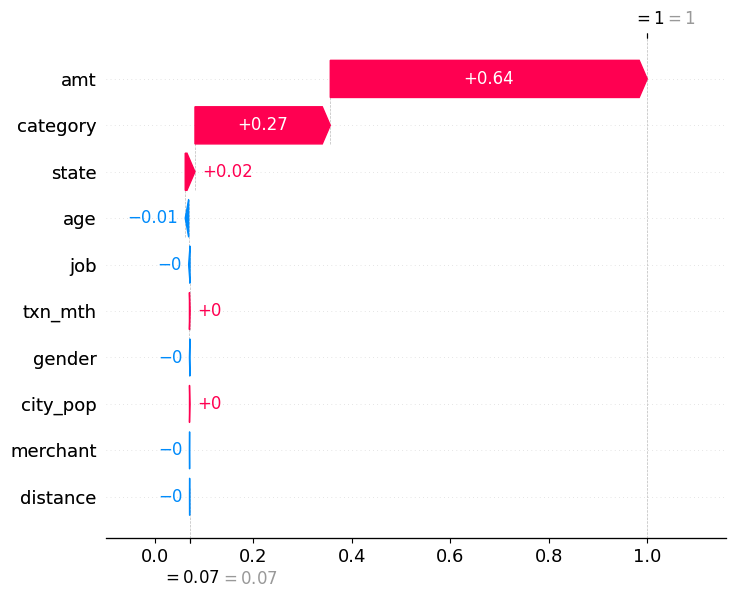

In [ ]:
#Waterfall cahrt for 1 observation
i = 2449
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],shap_values[1][i,:],
                                            feature_names=final_x_train.columns, max_display=20 )

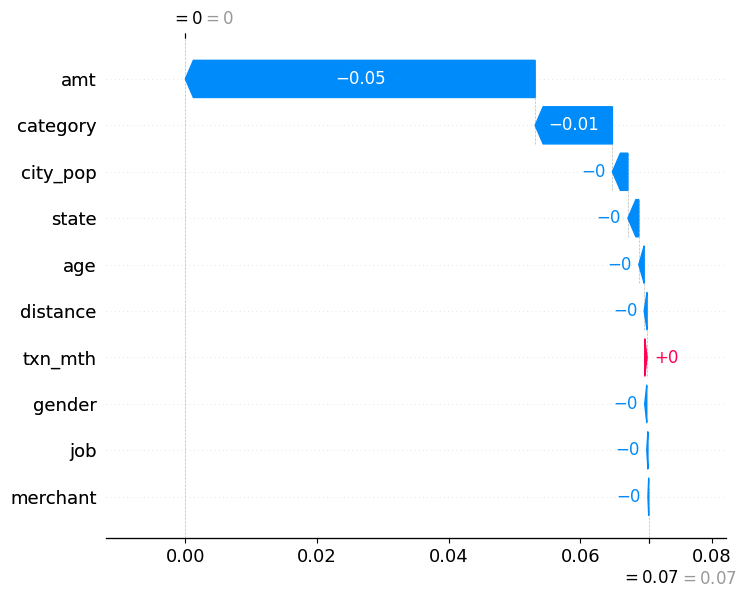

In [ ]:
i = 2
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],shap_values[1][i,:],
                                            feature_names=final_x_train.columns, max_display=20 )

3.2  Force plot

A force plot displays the contributions of each feature to the final prediction for a single instance, with each feature represented by a vertical bar. The height of each bar indicates the magnitude of the contribution of the feature, and the color indicates whether the contribution is positive or negative, with blue representing a positive contribution and red representing a negative contribution.

In [ ]:
#Force plot for 1 observation
shap.initjs()
i = 2449
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], features=final_x_train.iloc[i, :])

In [ ]:
#Force plot for 1 observation
shap.initjs()
i = 678
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], features=final_x_train.iloc[i, :])

In [ ]:
#Force plot for first 100 observations
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:], features=final_x_train.iloc[:100, :])

3.3 Decision plot


The key feature of a decision plot is that it shows how the predicted probability changes as a function of one or two input features, allowing users to explore how the model is making predictions and how it behaves at different points in the feature space

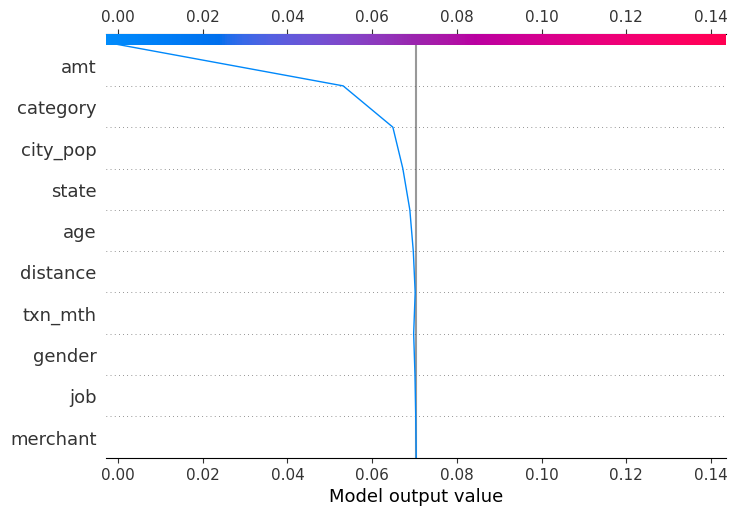

In [ ]:
#Decision plot for 1 observation
i = 2
shap.decision_plot(explainer.expected_value[1], shap_values[1][i,:], feature_names = list(final_x_train))

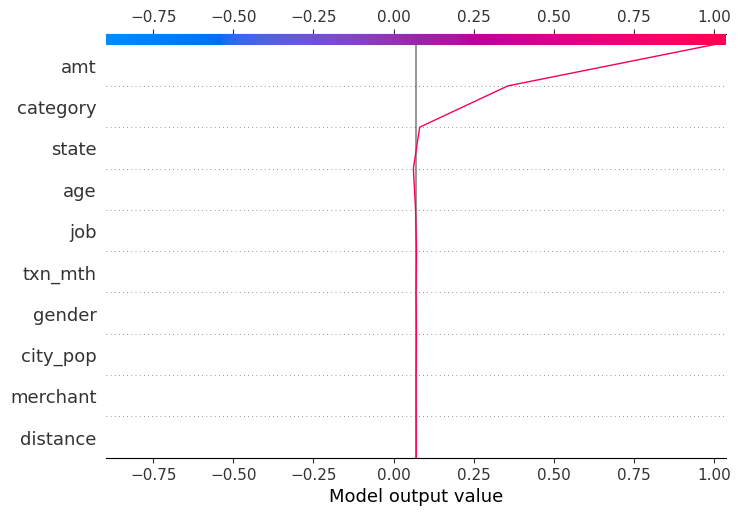

In [ ]:
i = 2449
shap.decision_plot(explainer.expected_value[1], shap_values[1][i,:], feature_names = list(final_x_train))

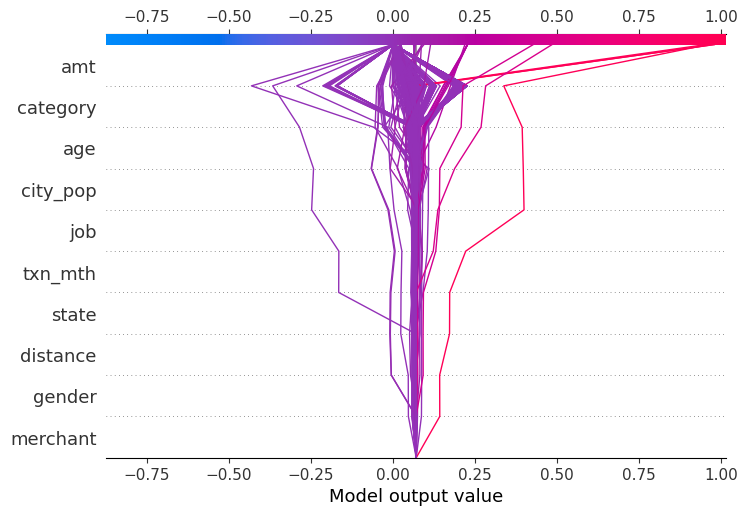

In [ ]:
#Decision plot for first 100 observations
shap.decision_plot(explainer.expected_value[1], shap_values[1][0:1000,:], feature_names = list(final_x_train))

4. Global Interpretation

4.1 Summary plot

The summary plot typically displays the most important features ranked in descending order of importance, along with a bar chart or heatmap indicating the magnitude of their importance.



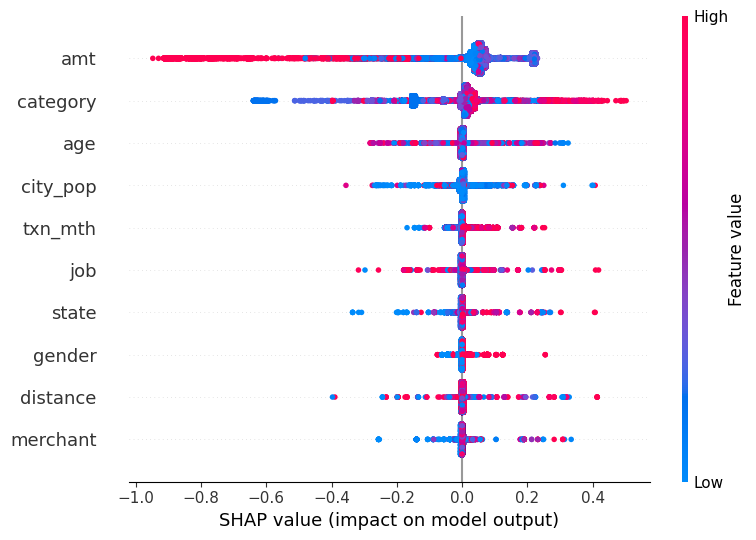

In [ ]:
#Summary plot dot
shap.summary_plot(shap_values[0], features=final_x_train,max_display = 10,plot_type='dot')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


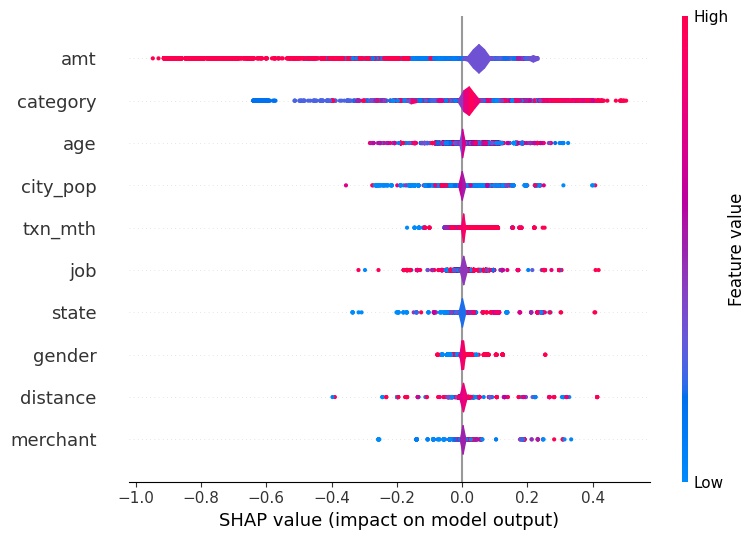

In [ ]:
#Summary violin
shap.summary_plot(shap_values[0], features=final_x_train,max_display = 10,plot_type='violin')

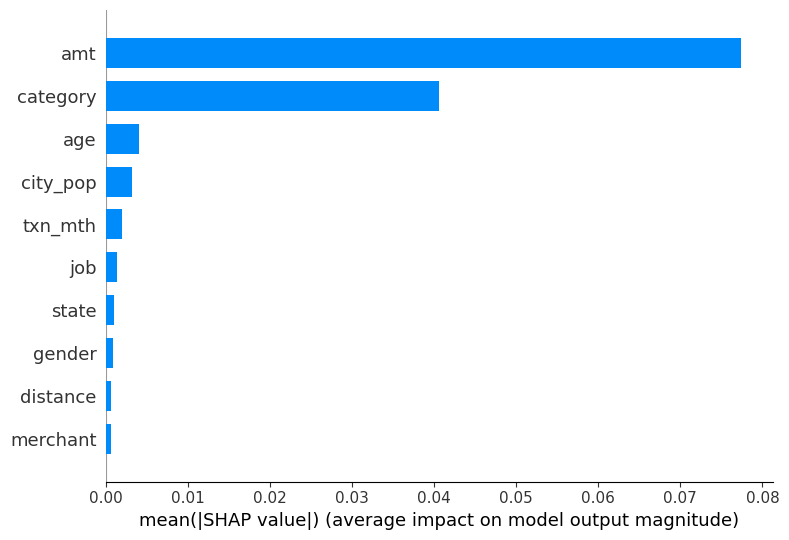

In [ ]:
#Summary plot relative importance
shap.summary_plot(shap_values[0], features=final_x_train,max_display = 10,plot_type='bar')

4.2 Dependence plot

The dependence plot can help users to understand how a specific input feature is affecting the model prediction, and to identify any non-linearities or interactions between features.

In [ ]:
final_x_train.columns

Index(['amt', 'city_pop', 'age', 'txn_mth', 'distance', 'merchant', 'category',
       'gender', 'state', 'job'],
      dtype='object')

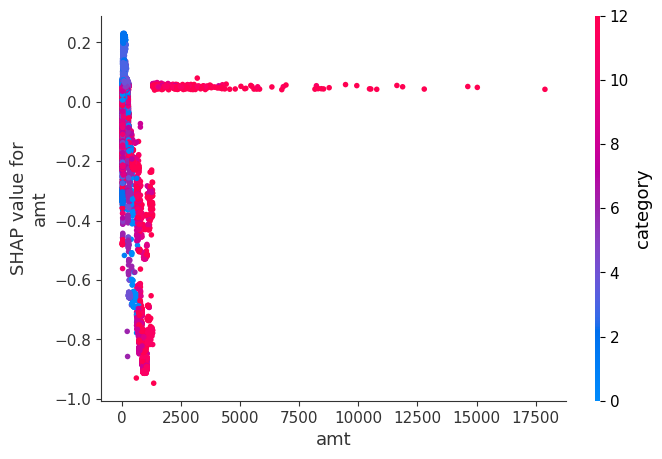

In [ ]:
shap.dependence_plot('amt',shap_values[0],final_x_train)

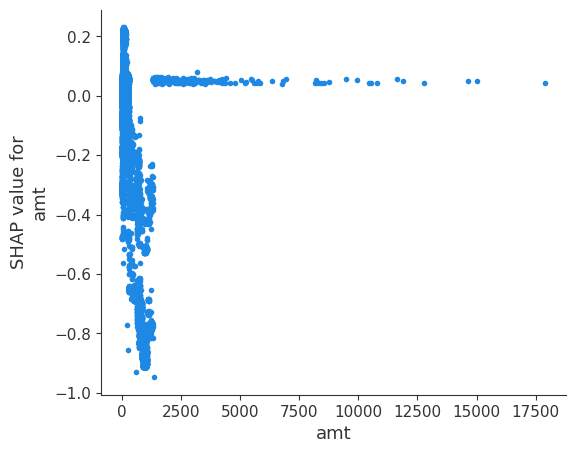

In [ ]:
shap.dependence_plot('amt',shap_values[0],final_x_train,interaction_index=None)

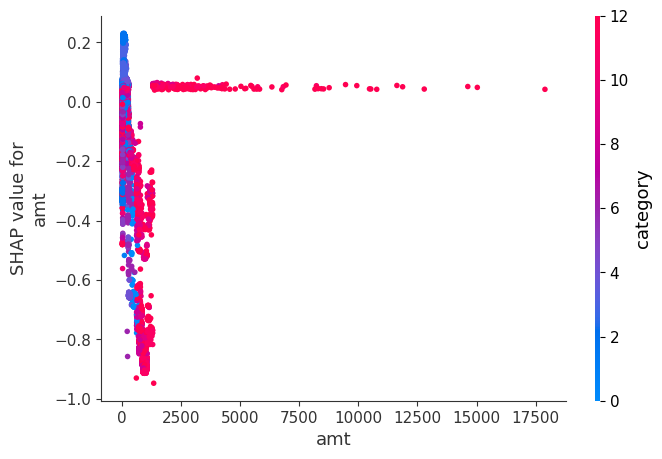

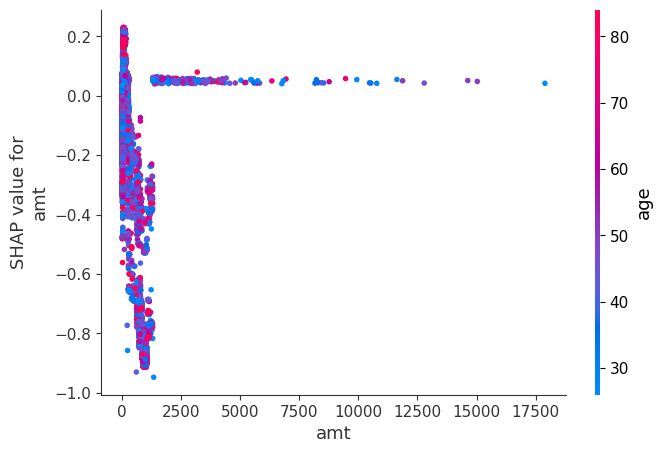

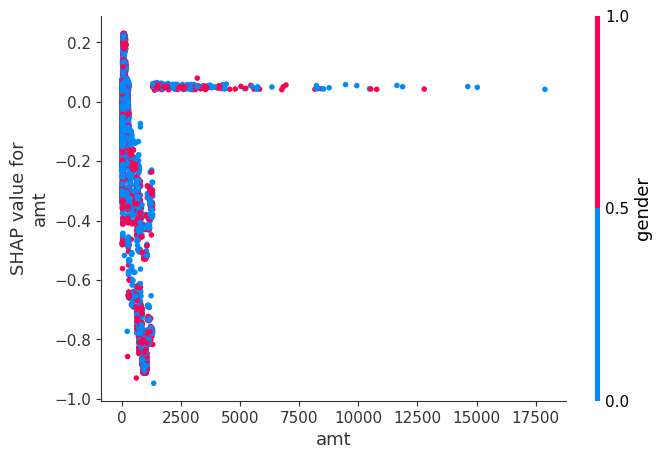

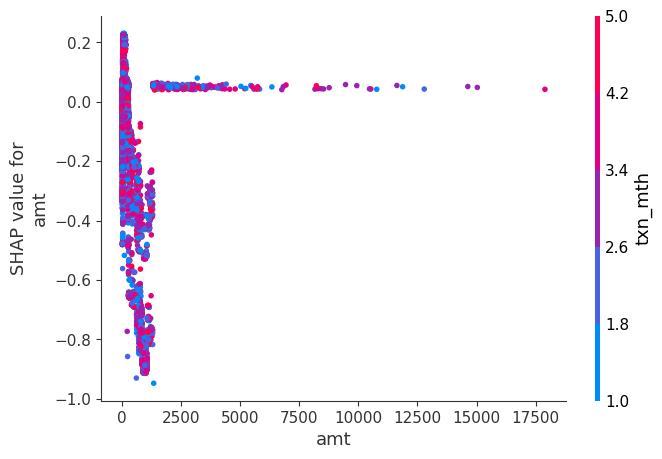

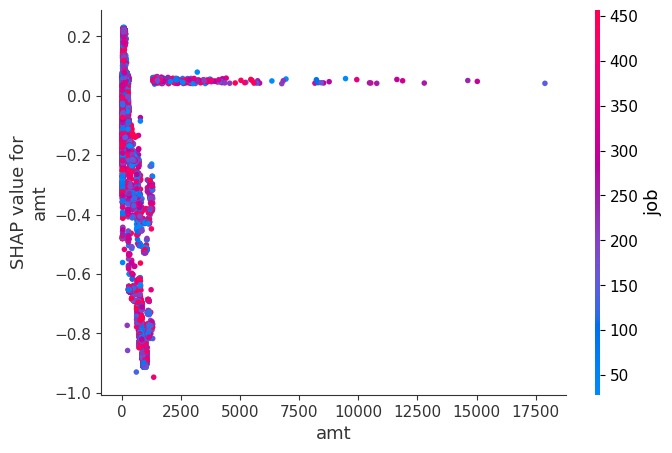

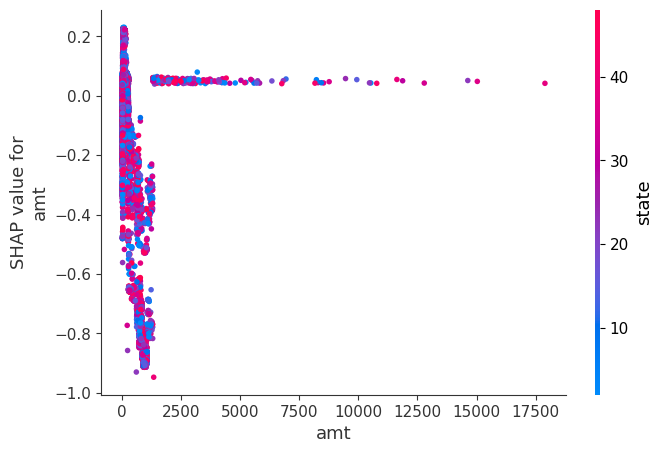

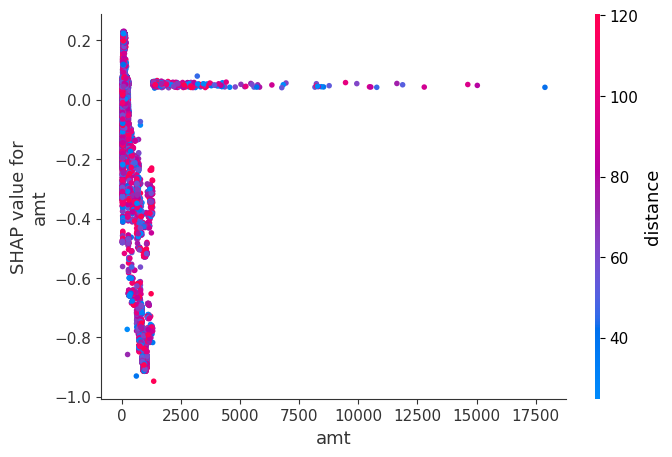

In [ ]:
inds= shap.approximate_interactions("amt",shap_values[0],final_x_train)

for i in range(7):
  shap.dependence_plot("amt",shap_values[0],final_x_train,interaction_index=inds[i])